In [ ]:
#Import the relevant packages:
import torch
import numpy as np, cv2, pandas as pd, glob, time
import matplotlib.pyplot as plt

%matplotlib inline
import torch.nn as nn
from torch import optim

import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision

from torchvision import transforms, models, datasets
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import os

import cv2

In [ ]:
# upload our Kaggle authentication file
! pip install kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# download the cats and dogs dataset and unzip it
! kaggle datasets download jangedoo/utkface-new

 98% 324M/331M [00:01<00:00, 192MB/s]
100% 331M/331M [00:01<00:00, 181MB/s]


In [ ]:
! unzip utkface-new.zip

In [ ]:
path = "/content/utkface_aligned_cropped/UTKFace"

In [ ]:
files = os.listdir(path)

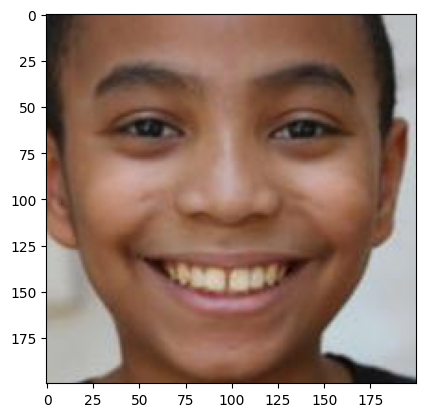

In [ ]:
img = cv2.imread("/content/utkface_aligned_cropped/UTKFace/10_0_1_20170110220507258.jpg.chip.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [ ]:
images=[]
ages=[]
gender=[]

for file in files:

    images.append(file)
    imgname = file.split("_")

    ages.append(int(imgname[0]))
    gender.append(int(imgname[1]))

In [ ]:
df = pd.DataFrame({"images": images , "ages":ages , "gender":gender } )
df.head()

,images,ages,gender
0,26_0_0_20170116182305836.jpg.chip.jpg,26,0
1,50_1_0_20170117174644414.jpg.chip.jpg,50,1
2,26_0_3_20170119192402842.jpg.chip.jpg,26,0
3,7_1_1_20170112210604630.jpg.chip.jpg,7,1
4,26_0_1_20170117195923557.jpg.chip.jpg,26,0


In [ ]:

from torch.utils.data import Dataset, DataLoader
import cv2
IMAGE_SIZE = 224

class GenderAgeClass(Dataset):
    def __init__(self, df, tfms=None):

        self.df = df
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])
    def __len__(self): return len(self.df)

    def __getitem__(self, ix):

        f = self.df.iloc[ix].squeeze()
        file = f.file
        gen = f.gender == 'Female'
        age = f.age
        im = cv2.imread(file)
        im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        return im, age, gen

    def preprocess_image(self, im):

        im = cv2.resize(im, (IMAGE_SIZE, IMAGE_SIZE))
        im = torch.tensor(im).permute(2,0,1)
        im = self.normalize(im/255.)
        return im[None]

    def collate_fn(self, batch):

        'preprocess images, ages and genders'
        ims, ages, genders = [], [], []
        for im, age, gender in batch:

            im = self.preprocess_image(im)
            ims.append(im)

            ages.append(float(int(age)/80))
            genders.append(float(gender))

        ages, genders = [torch.tensor(x).to(device).float() for x in [ages, genders]]
        ims = torch.cat(ims).to(device)

        return ims, ages, genders

In [ ]:
trn = GenderAgeClass(trn_df)
val = GenderAgeClass(val_df)

In [ ]:
train_df=df.sample(frac=1,random_state=0).iloc[:18000]
test_df=df.sample(frac=1,random_state=0).iloc[18000:]

In [ ]:
train_loader = DataLoader(ttrain_datasets, batch_size=32, shuffle=True, drop_last=True)
test_loader = DataLoader(val_datasets, batch_size=32)

In [ ]:
def get_model():

    model = models.vgg16(pretrained = True)
    # Freeze parameters so we don't backprop through them
    for param in model.parameters():
        param.requires_grad = False

    model.avgpool = nn.Sequential(
        nn.Conv2d(512,512, kernel_size=3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Flatten()
    )
    class ageGenderClassifier(nn.Module):
        def __init__(self):

            super(ageGenderClassifier, self).__init__()
            self.intermediate = nn.Sequential(
                nn.Linear(2048,512),
                nn.ReLU(),
                nn.Dropout(0.4),
                nn.Linear(512,128),
                nn.ReLU(),
                nn.Dropout(0.4),
                nn.Linear(128,64),
                nn.ReLU(),
            )

            self.age_classifier = nn.Sequential(
                nn.Linear(64, 1),
                nn.Sigmoid()
            )

            self.gender_classifier = nn.Sequential(
                nn.Linear(64, 1),
                nn.Sigmoid()
            )

        def forward(self, x):

            x = self.intermediate(x)
            age = self.age_classifier(x)
            gender = self.gender_classifier(x)

            return gender, age

    model.classifier = ageGenderClassifier()

    gender_criterion = nn.BCELoss()
    age_criterion = nn.L1Loss()

    loss_functions = gender_criterion, age_criterion
    optimizer = torch.optim.Adam(model.parameters(), lr= 1e-4)

    return model.to(device), loss_functions, optimizer

model, loss_functions, optimizer = get_model()

In [ ]:
!pip install torchsummary
from torchsummary import summary
summary(model, input_size=(3,224,224), device=device)

In [ ]:
!pip install torchsummary
from torchsummary import summary
summary(model, input_size=(3,224,224), device=device)

In [ ]:
def train_batch(data, model, optimizer, criteria):
    model.train()

    ims, age, gender = data
    optimizer.zero_grad()
    pred_gender, pred_age = model(ims)
    gender_criterion, age_criterion = criteria

    gender_loss = gender_criterion(pred_gender.squeeze(), gender)
    age_loss = age_criterion(pred_age.squeeze(), age)
    total_loss = gender_loss + age_loss

    total_loss.backward()
    optimizer.step()

    return total_loss

def validate_batch(data, model, criteria):
    model.eval()

    ims, age, gender = data
    with torch.no_grad():
      pred_gender, pred_age = model(ims)

    gender_criterion, age_criterion = criteria
    gender_loss = gender_criterion(pred_gender.squeeze(), gender)
    age_loss = age_criterion(pred_age.squeeze(), age)
    total_loss = gender_loss + age_loss

    pred_gender = (pred_gender > 0.5).squeeze()
    gender_acc = (pred_gender == gender).float().sum()
    age_mae = torch.abs(age - pred_age).float().sum()

    return total_loss, gender_acc, age_mae

In [ ]:
model, criteria, optimizer = get_model()

val_gender_accuracies = []
val_age_maes = []

train_losses = []
val_losses = []

n_epochs = 5

for epoch in range(n_epochs):
    val_age_mae, val_gender_acc, ctr = 0, 0, 0
    _n = len(train_loader)
    for ix, data in enumerate(train_loader):
        # if ix == 100: break
        loss = train_batch(data, model, optimizer, criteria)

    for ix, data in enumerate(test_loader):
        # if ix == 10: break
        loss, gender_acc, age_mae = validate_batch(data, model, criteria)
        val_age_mae += age_mae
        val_gender_acc += gender_acc

        ctr += len(data[0])

    val_age_mae /= ctr
    val_gender_acc /= ctr


    val_gender_accuracies.append(val_gender_acc)
    val_age_maes.append(val_age_mae)